# PSB injection bump in Xsuite - track!

In [1]:
%matplotlib notebook

In [2]:
# Import modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import xtrack as xt
import xpart as xp
import xdeps as xd

from cpymad.madx import Madx

/Users/giadarol/xsuite_packages/xtrack/xtrack/progress_indicator.py:90: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


###  Load line from previous notebook

In [3]:
# Reload
line = xt.Line.from_json('psb_04_with_chicane_corrected_thin.json')
line.build_tracker()
tw = line.twiss()

Loading line from dict:   0%|          | 0/2395 [00:00<?, ?it/s]

Done loading line from dict.           
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `only_xtrack_frozen_energy`.


### Switch on RF

In [4]:
line.vars['v_rf'] = 8e3 # V
line.vars['f_rf'] = 1 / tw.T_rev0 # h = 1

In [5]:
# Inspect
line.element_refs['br1.acwf7l1.1'].voltage = line.vars['v_rf']
line.element_refs['br1.acwf7l1.1'].frequency = line.vars['f_rf']

We can switch to 6d method as default for the twiss

In [6]:
line.twiss_default['method'] = '6d'

In [7]:
# Check synchrotron tune (confirms that longitudinal motion is stable)
tw6d = line.twiss()
tw6d.qs

0.0017021494299826467

### Enable chicane and chicane correction

In [8]:
line.vars['on_chicane_k0'] = 1
line.vars['on_chicane_k2'] = 1
line.vars['on_chicane_beta_corr'] = 1
line.vars['on_chicane_tune_corr'] = 1

### Install monitor at foil

In [9]:
monitor = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=6000, particle_id_range=(0,5))

line.discard_tracker()
line.insert_element(index='bi1.tstr1l1', element=monitor, name='monitor_at_foil')
line.build_tracker()

Found suitable prebuilt kernel `default_only_xtrack`.


### Generate a bunch

In [10]:
p = xp.generate_matched_gaussian_bunch(num_particles=50, sigma_z=2., nemitt_x=1e-6, nemitt_y=1.5e-6, line=line)

# use the first particle as probe
p.x[0] = 0
p.px[0] = 0
p.y[0] = 0
p.py[0] = 0
p.zeta[0] = 0
p.delta[0] = 0

### Enable time-dependent variables (update `t_turn_s` automatically during tracking)

In [11]:
line.enable_time_dependent_vars = True
line.dt_update_time_dependent_vars = 3e-6
line.vars.cache_active = True

In [12]:
print('Tracking...')
line.track(p, num_turns=6000, time=True)
print(f'Done in {line.time_last_track:.4} s')

Tracking...
Done in 12.7 s


<IPython.core.display.Javascript object>


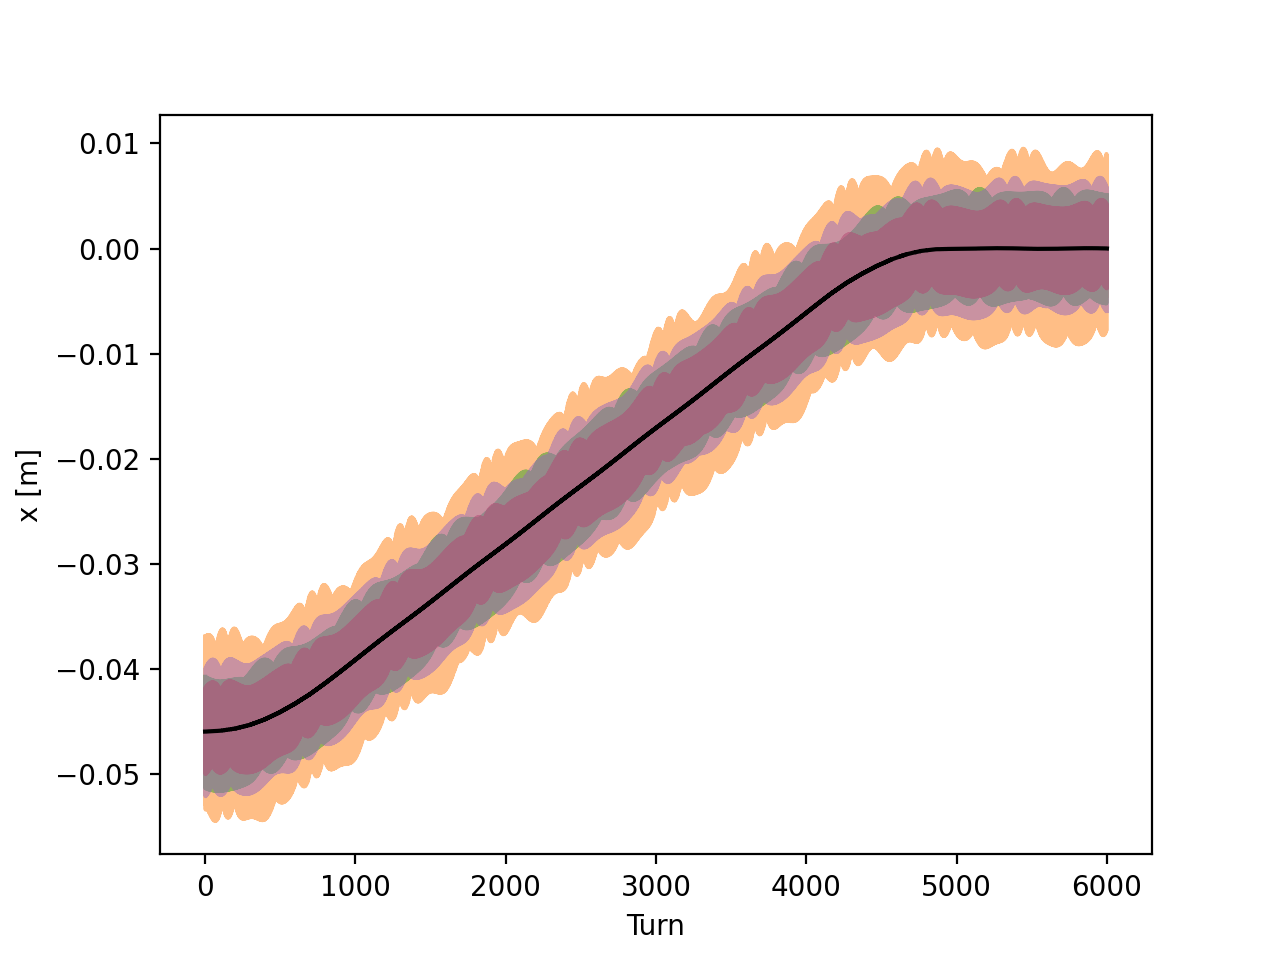

In [13]:
import matplotlib.pyplot as plt
plt.close('all')
plt.figure(1)
plt.plot(monitor.x.T, alpha=0.5)
plt.plot(monitor.x[0, :], color='black') # particle on closed orbit
plt.xlabel('Turn')
plt.ylabel('x [m]')
plt.show()

-------